# RouteZero MVP notebook
The goal of this notebook is to provide a start to end example of how a user would supply data and get results from RouteZero. This can then be used as a starting point for the User Inteface design. Some parts of the back end algorithms are incomplete or not solved yet, where this is the case dummy outputs have been used and a note has been made.

The general design for this follows the specifications at https://app.clickup.com/6964607/v/dc/6mhbz-8442

Summary of open questions:
- battery charging effiencies (default with optional adjustment 0.9 default)
- state of health of batteries (end of life state of health / capacity at end of life 80% default)

# User inputs
The user will be required to input the following information:
- Route information (GTFS)
- Timetable information (GTFS)
- Passenger loading (normal and peak)
- Select bus from list which defines
    - battery capacity
    - mass
    - passenger capacity
    - charging rate limit
- Type of charger (max charging rate or charger)
- (optional) A specific sequence of routes to check for feasibility (should this be specified as route or route + direction?)

# Route and timetable information
This information will be provided as GTFS data (potentially with an option to manually provide the same data in some way). Currently, this example uses the public sydney gtfs data obtained from https://opendata.transport.nsw.gov.au/dataset/timetables-complete-gtfs. Reading in the GTFS file can take some time.

After providing/selecting the gtfs data to use. All bus routes in the list should be read in and then the user should choose which ones to consider.

Incomplete functionality:
- This needs an option to select from a few likely feeds or for the user to upload there own.
- This option currently reads in the timetable for the busiest day of the year only and replicates this seven times to produce a busiest week. This needs to be changed to use the busiest week of the timetable, however this was slightly non-trivial due to data size but is definitely doable.
- The function to read in the data and do some initial parsing is time consuming and not very efficient, this could be addressed.
- manual entry

In [1]:
import gtfs_functions as gtfs
gtfs_file = "./data/full_greater_sydney_gtfs_static.zip"         # location of the gtfs zip file
import time
t1 = time.time()
routes, stops, stop_times, trips, shapes = gtfs.import_gtfs(gtfs_file, busiest_date=True)   # read in data and do some initial processing, can take some time
t2 = time.time()
print(t2-t1)

79.46808362007141


Filter to bus routes only

In [2]:
bus_routes = routes.loc[(routes.route_type >= 700) & (routes.route_type < 800)].reset_index()

User can choose to narrow down to particular route descriptions

In [3]:
import ipywidgets as widgets
route_descriptions = list(bus_routes.route_desc.unique())
desc_selector = widgets.SelectMultiple(
    options=route_descriptions,
    value=['Sydney Buses Network'],
    #rows=10,
    description='Route descriptions',
    disabled=False
)

display(desc_selector)

SelectMultiple(description='Route descriptions', index=(1,), options=('Illawarra Buses Network', 'Sydney Buses…

In [6]:
# filter down to only the selected descriptions
route_desc_sel = desc_selector.value
assert len(route_desc_sel) > 0, 'Must select at least one route description'
print('Filtering to routes with descriptions in: ', route_desc_sel)
bus_routes = bus_routes.loc[bus_routes['route_desc'].isin(route_desc_sel)].reset_index()

Filtering to routes with descriptions in:  ('Sydney Buses Network',)


ValueError: cannot insert level_0, already exists


User selects which routes to consider

In [5]:
route_short_names = list(bus_routes.route_short_name)
route_selector = widgets.SelectMultiple(
    options=route_short_names,
    value=route_short_names[0:10],
    #rows=10,
    description='Routes',
    disabled=False
)

display(route_selector)

SelectMultiple(description='Routes', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), options=('668', '671', '672', '673'…

In [7]:
routes_sel = route_selector.value
assert len(routes_sel) > 0, 'must select at least one route'
print('The following routes have been selected:')
print(routes_sel)

The following routes have been selected:
('668', '671', '672', '673', '674', '675A', '675C', '676', '677', '678')


Filter data down to selected routes and do some preprocessing so that we have all the information required for the energy consumption model

In [8]:

from gtfs_routes import preprocess_selected_route_data
cutoffs = [0, 6, 9, 15, 19, 22, 24, 30]  # time windows to split trip data into to assess differences in say traffic etc
route_data, subset_shapes, elevation_profiles, trip_totals, subset_stops = preprocess_selected_route_data(routes_sel, bus_routes, shapes, stops, stop_times, trips, cutoffs)

route_data.head()

,route_id,direction_id,shape_id,window,trip_distance,trip_start_time,trip_end_time,trip_duration,average_speed_mps,num_stops,stops_km,av_grade_%,start_location,end_location
2,20-668-sj2-1,0,20-668-sj2-1.1.H,12.0,10844.87,38760.0,40020.0,1260.0,8.607040,18.0,1.659771,-0.322921,"(150.839060369539, -33.5534140673437)","(150.811503580547, -33.6137158371643)"
23,20-668-sj2-1,0,20-668-sj2-1.4.H,12.0,23193.25,53100.0,54900.0,1800.0,12.885139,35.0,1.509060,0.176722,"(150.752215333905, -33.5987799600136)","(150.77800106772, -33.5355665501484)"
24,20-668-sj2-1,0,20-668-sj2-1.4.H,17.0,23193.25,59700.0,61500.0,1800.0,12.885139,35.0,1.509060,0.176722,"(150.752215333905, -33.5987799600136)","(150.77800106772, -33.5355665501484)"
232,20-668-sj2-1,1,20-668-sj2-1.2.R,7.5,21874.37,32040.0,34020.0,1980.0,11.047662,35.0,1.600046,-0.228513,"(150.772614748288, -33.535939707948)","(150.752370015645, -33.5985548295533)"
233,20-668-sj2-1,1,20-668-sj2-1.2.R,12.0,21874.37,42540.0,44520.0,1980.0,11.047662,35.0,1.600046,-0.228513,"(150.772614748288, -33.535939707948)","(150.752370015645, -33.5985548295533)"


# User enters passenger loading information
This should be the nominal and peak passenger loading for each route.

Incomplete functionality:
- although the backend can work with per route passenger loading, the input is just one value atm

In [9]:
nominal_passenger_loading = 20
peak_passenger_loading = 50

# Bus information
Select bus from list or manually enter the values required.

Incomplete functionality:
- Where would we get the other bus data from??
- manual entry
- energy consumption model does not currently take into account the mass

Missing bus data
- Don't have charging rates for buses
- Don't have nominal range for Yutong bus
- Dont have max passenger for BYD
Made these values up where needed

In [10]:
bus_options = ['Yutong', 'BYD']
bus_selector = widgets.Select(
    options=bus_options,
    value='Yutong',
    description='Bus',
    disabled=False
)

display(bus_selector)

Select(description='Bus', options=('Yutong', 'BYD'), value='Yutong')

In [11]:
bus = bus_selector.value
if bus=='Yutong':
    bus_max_passenger = 74                          # value comes from website
    bus_mass = 18000 - bus_max_passenger * 65      # gross from spec sheet minus passenger * 65 as per spec sheet
    bus_battery = 422                               # kWh
    bus_charge_rate = 300                              # website gives three options 60kW, 150kW, 300kW
elif bus=='BYD':
    bus_battery = 368                               # kwh
    norminal_urban_range = 250                      # kms
    bus_max_passenger = 74                          # made this value up (copied yuton)
    bus_mass = 18000 - 65 * bus_max_passenger
    charge_time = 4.6                               # hours from spec sheet (this might not actually be minimum, just some standard)
    bus_charge_rate = bus_battery / charge_time     # kw
else:
    print('Invalid bus chosen')

print('Chosen bus: ', bus)
print('The following parameters will be used based on this choice')
print('max passengers: ', bus_max_passenger)
print('bus battery capacity (kWh)', bus_battery)
print('Bus maximum charge rate (kW)', bus_charge_rate)

# Here we can quickly check if the bus has teh required passenger capacity  (this should be modified to be per route)
assert bus_max_passenger > peak_passenger_loading, 'Bus passenger capacity must be greater than peak passenger loading on all routes'

Chosen bus:  Yutong
The following parameters will be used based on this choice
max passengers:  74
bus battery capacity (kWh) 422
Bus maximum charge rate (kW) 300


# Charger information
I think this is actually bus specific and so would be the busses rate of charge. No separate values added at present

# Sequence of routes
This would be an optional input. User specifies a sequence of routes that the model will check if a bus could feasibly do without recharge.

Warning:
- If this isn't a round trip sequence then it doesn't have a way of factoring in return to depot in an accurate way

In [12]:
sequence_selector = widgets.SelectMultiple(
    options=routes_sel,
    value=routes_sel[0:3],
    #rows=10,
    description='sequence',
    disabled=False
)

display(sequence_selector)

SelectMultiple(description='sequence', index=(0, 1, 2), options=('668', '671', '672', '673', '674', '675A', '6…

In [13]:
route_sequence = sequence_selector.value
print('Chosen route sequence is ', route_sequence )

Chosen route sequence is  ('668', '671', '672')


# First pass calculations
This first pass calculations will look into two aspects

Route feasibility information:
- Energy required for each route as total kWh and kWh/km
- From the above, is each route feasible
- if sequence was provided, is the sequence feasible

Depot and timetable minimum feasibility requirements:
- Minimum number of buses based on max buses on route at a given time
- Minimum grid connection limit at the depot
- Minimum number of chargers

This requires a couple of parameters to be set for which there will be defaults:
- Between route deadhead time and energy (nominally 10% of route time and energy)
- depot deadhead time i.e. additional time for returning and starting/finishing charge (nominally 15 mins)

Incomplete functionality:
- currently, not factoring in time of day of the bus trips when using the results from energy predictions for this step or later steps

 Select deadhead time and energy % (factored as a percent of the route time and energy)



In [14]:
slider_1 = widgets.FloatSlider(
    value=10,
    min=0,
    max=100.0,
    step=1.,
    description='deadhead (%)',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
display(slider_1)

FloatSlider(value=10.0, continuous_update=False, description='deadhead (%)', readout_format='.1f', step=1.0)

Select dead time for returning and departing from depot in minutes (should this also be an eneryg factor?)

In [15]:
slider_2 = widgets.FloatSlider(
    value=15,
    min=0,
    max=30.0,
    step=1.,
    description='deadtime',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
display(slider_2)


FloatSlider(value=15.0, continuous_update=False, description='deadtime', max=30.0, readout_format='.1f', step=…

In [16]:
deadhead = slider_1.value/100
deadtime = slider_2.value
print('Between trip deadhead time and energy percentage is {}%'.format(deadhead*100))
print('Depot return and depart dead time is {}'.format(deadtime))

Between trip deadhead time and energy percentage is 10.0%
Depot return and depart dead time is 15.0


# Route Feasibility
Stage one of the first pass calculations is to compute the route feasibility which looks at the predicted energy consumption on each route under good and bad conditions. This does the following steps:
1. determine probable min and max yearly temperatures for the location
2. predict the energy consumption on each of these routes
3. predict the energy usage

Determining min and max probable yearly temperatures for each route based on location

In [17]:
from weather import location_design_temp
# get design day temperatures for route locations
min_temps = []
max_temps = []
# avg_temps = []
for i, r in route_data.iterrows():
    location_coords = (r['start_location'][1], r['start_location'][0] ) # geometry locations are (E, N) not (N, E)...
    elevation = elevation_profiles[r['shape_id']].mean()
    min_temp, max_temp, avg_temp = location_design_temp(location_coords, elevation, num_years=10, percentiles=[1, 99])
    min_temps.append(min_temp)
    max_temps.append(max_temp)
    # avg_temps.append(avg_temp)

route_data['min_temp'] = min_temps
route_data['max_temp'] = max_temps

# Predict the energy consumption for each route
Min energy consumption is based off best case temperature, nominal driver aggressiveness, good road conditions, and nominal passenger loading
Max energy consumption is based off worst case temperature, max driver aggressiveness, bad road conditions (raining etc), and peak passenger loading

not implemented:
- current model doesn't take into account mass of bus
- not interpretation of night time vs daytime temperatures

In [18]:
from ebus_energy_models import LinearRegressionAbdelatyModel
model = LinearRegressionAbdelatyModel()
route_data = model.predict_routes(route_data, PL=nominal_passenger_loading, PL_peak=peak_passenger_loading, Dagg=[2,3], RC=[1,3])

Energy consumption for the sequence

In [19]:
sequence_ids = bus_routes[bus_routes['route_short_name'].isin(route_sequence)].route_id
sequence_data = route_data[route_data['route_id'].isin(sequence_ids)]
for i in range(len(sequence_ids)):
    SOC_best = bus_battery
    SOC_worst = bus_battery
    tmp_data = route_data[route_data['route_id']==sequence_ids[i]]
    tmp_data = model.predict_routes(tmp_data.copy(),SoCi=[SOC_best,SOC_worst],PL=nominal_passenger_loading, PL_peak=peak_passenger_loading, Dagg=[2,3], RC=[1,3])
    SOC_worst -= tmp_data['max_EC_total'].max() * (1+deadhead)
    SOC_best -= tmp_data['min_EC_total'].max() * (1+deadhead)

print('Energy consumption for the sequence of routes specified: ', route_sequence)
print('minimum predicted energy usage is ', bus_battery - SOC_best, ' kWh')
print('maximum predicted energy usage is ', bus_battery - SOC_worst, 'kWh')
print('In the predicted worst case the bus would have ', SOC_worst, ' kWh remaining')
print('This does not factor in energy to get to first route from depot or energy to get from last route back to depot')
print('Energy usage between routes is approximated using the deadhead factor set to ', deadhead*100, '%')

Energy consumption for the sequence of routes specified:  ('668', '671', '672')
minimum predicted energy usage is  178.22075117568238  kWh
maximum predicted energy usage is  235.13028506568241 kWh
In the predicted worst case the bus would have  186.86971493431759  kWh remaining
This does not factor in energy to get to first route from depot or energy to get from last route back to depot
Energy usage between routes is approximated using the deadhead factor set to  10.0 %


# Plot results from first pass calculations or output

In [20]:
import geopandas as gpd
import numpy as np
import folium
import webbrowser
import branca

def folium_open(f_map, path):
    html_page = f'{path}'
    f_map.save(html_page)
    # open in browser.
    new = 2
    webbrowser.open(html_page, new=new)


gdf = gpd.GeoDataFrame(subset_shapes)
gdf['route_id'] = "nan"
gdf['max_EC_total'] = np.nan
gdf['max_EC_km'] = np.nan

for i, s in gdf.iterrows():
    shape_id = s['shape_id']
    max_EC_total = route_data[route_data.shape_id==shape_id].max_EC_total
    max_EC_km = route_data[route_data.shape_id == shape_id].max_EC_km
    route_id = route_data[route_data.shape_id == shape_id].route_id.to_numpy()[0]
    if len(max_EC_total):
        gdf.at[i, 'max_EC_total'] = max(max_EC_total)
        gdf.at[i, 'max_EC_km'] = max(max_EC_km)
        gdf.at[i, 'route_id'] = route_id

gdf.dropna(inplace=True)

minx, miny, maxx, maxy = gdf.geometry.total_bounds

centroid_lat = miny + (maxy - miny) / 2
centroid_lon = minx + (maxx - minx) / 2

## create a map of total energy consumption
m = folium.Map(location=[centroid_lat, centroid_lon],
               tiles='cartodbpositron', zoom_start=12)
gdf.crs = {'init': 'epsg:4326'}

colorscale = branca.colormap.linear.YlGnBu_09.scale(gdf['max_EC_total'].min(), gdf['max_EC_total'].max())


def style_function(feature):
    return {
        'fillOpacity': 0.5,
        'weight': 3,  # math.log2(feature['properties']['speed'])*2,
        'color': colorscale(feature['properties']['max_EC_total'])
    }


# my code for lines
geo_data = gdf.__geo_interface__
folium.GeoJson(
    geo_data,
    style_function=style_function,
    tooltip=folium.features.GeoJsonTooltip(fields=['route_id', 'max_EC_total'],
                                           # aliases=tooltip_labels,
                                           labels=True,
                                           sticky=False)
).add_to(m)

# adding a title
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format("Route Energy Consumption")
m.get_root().html.add_child(folium.Element(title_html))

# adding a legend
colorscale.caption = 'Energy consumption (kwh)'
colorscale.add_to(m)

display(m)
# folium_open(m, 'test.html')

# Depot feasibility
Second part of the first pass calculations looks at the depot feasibility
1. Work out minimum number of buses based on buses in traffic graph
2. Work out connection capacity and number of chargers required at the depot (assuming no battery, and minimum number of buses)

Buses in traffic graph

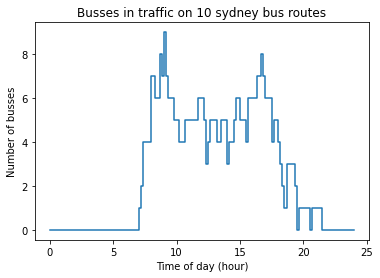

Minimum number of busses required to service these routes is  9


In [21]:
import matplotlib.pyplot as plt
resolution = 10      # resolution in 10 mins
wrap_time = 24*60
time_slot_edges = np.arange(0, 30*60, resolution)      # time slot edges in minutes

buffered_time_starts = trip_totals.trip_start_time/60 - trip_totals.trip_duration/60*(deadhead/2)


c_starts = np.histogram(buffered_time_starts, bins=time_slot_edges)[0]

buffered_time_ends = trip_totals.trip_start_time/60 + trip_totals.trip_duration/60*(1+deadhead/2)
c_ends = np.histogram(buffered_time_ends, bins=time_slot_edges)[0]

busses_in_traffic = np.cumsum(c_starts) - np.cumsum(c_ends)

t_starts = time_slot_edges[:-1]
wrap_inds = t_starts > wrap_time    # todo: apply wrap to start as well in some way consistently
busses_in_traffic[:sum(wrap_inds)] = busses_in_traffic[:sum(wrap_inds)]+busses_in_traffic[wrap_inds]

t_wrap = t_starts[~wrap_inds]
busses_in_traffic_wrap = busses_in_traffic[~wrap_inds]

plt.step(t_wrap/60, busses_in_traffic_wrap)
plt.title('Busses in traffic on {} sydney bus routes'.format(len(routes_sel)))
plt.xlabel('Time of day (hour)')
plt.ylabel('Number of busses')
plt.show()

print('Minimum number of busses required to service these routes is ',max(busses_in_traffic_wrap))

work out energy requirements graphs

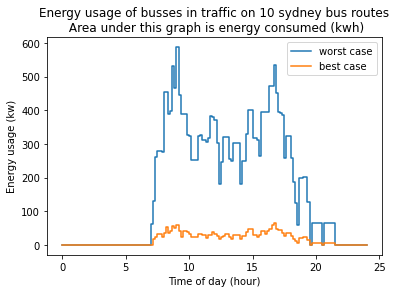

In [22]:
trip_totals['max_EC_total'] = np.nan
trip_totals['min_EC_total'] = np.nan
for i, r in route_data.iterrows():
    window = r.window
    shape_id = r.shape_id
    max_EC_total = r.max_EC_total
    min_EC_total = r.min_EC_total
    inds = (trip_totals.shape_id==shape_id) & (trip_totals.window==window)
    # trip_totals[inds]['max_EC_total'] == max_EC_total
    trip_totals.loc[inds, 'max_EC_total'] = max_EC_total
    trip_totals.loc[inds, 'min_EC_total'] = min_EC_total

# work out energy requirements of busses current in traffic
# worst case first

# energy usage in kw
energy_usage = trip_totals.max_EC_total*(1+deadhead) / (trip_totals.trip_duration*(1+deadhead)/60/60)
e_starts = np.histogram(buffered_time_starts, bins=time_slot_edges, weights=energy_usage)[0]
e_ends = np.histogram(buffered_time_ends, bins=time_slot_edges, weights=energy_usage)[0]

energy_req_busses_max = np.cumsum(e_starts) - np.cumsum(e_ends)

energy_req_busses_max[:sum(wrap_inds)] = energy_req_busses_max[:sum(wrap_inds)]+energy_req_busses_max[wrap_inds]
energy_req_busses_max_wrap = energy_req_busses_max[~wrap_inds]

# best case
energy_usage = trip_totals.min_EC_total * (1 + deadhead) / (trip_totals.trip_duration*(1+deadhead) / 60 / 60)
e_starts = np.histogram(trip_totals.trip_start_time/60, bins=time_slot_edges, weights=energy_usage)[0]
e_ends = np.histogram(buffered_time_ends, bins=time_slot_edges, weights=energy_usage)[0]

energy_req_busses_min = np.cumsum(e_starts) - np.cumsum(e_ends)


energy_req_busses_min[:sum(wrap_inds)] = energy_req_busses_min[:sum(wrap_inds)]+energy_req_busses_min[wrap_inds]
energy_req_busses_min_wrap = energy_req_busses_min[~wrap_inds]

# shift after 24 hours to morning


plt.step(t_wrap/60,energy_req_busses_max_wrap,label='worst case')
plt.step(t_wrap/60, energy_req_busses_min_wrap, label='best case')
plt.ylabel('Energy usage (kw)')
plt.title('Energy usage of busses in traffic on {} sydney bus routes'.format(len(routes_sel))+'\n Area under this graph is energy consumed (kwh)')
plt.xlabel('Time of day (hour)')
plt.legend()
plt.show()

Prepare data for depot charging optimisation

In [23]:

busses_at_depot = max(busses_in_traffic_wrap) - busses_in_traffic_wrap
depart_trip_energy_reqs = np.histogram(buffered_time_starts, bins=time_slot_edges, weights=trip_totals.max_EC_total*(1+deadhead))[0]
return_trip_enery_consumed = np.histogram(buffered_time_ends, bins=time_slot_edges, weights=trip_totals.max_EC_total*(1+deadhead))[0]
depart_trip_energy_reqs[:sum(wrap_inds)] = depart_trip_energy_reqs[:sum(wrap_inds)]+depart_trip_energy_reqs[wrap_inds]
depart_trip_energy_reqs = depart_trip_energy_reqs[~wrap_inds]
return_trip_enery_consumed[:sum(wrap_inds)] = return_trip_enery_consumed[:sum(wrap_inds)]+return_trip_enery_consumed[wrap_inds]
return_trip_enery_consumed = return_trip_enery_consumed[~wrap_inds]


import pandas as pd
optim_data = pd.DataFrame(index=t_wrap,columns=['ED','ER','Nt'])
optim_data['ED'] = depart_trip_energy_reqs
optim_data['ER'] = return_trip_enery_consumed
optim_data['Nt'] = busses_at_depot


In [24]:
from depot_optimisation import feas_optim

feasibility_results = feas_optim(optim_data, bus_battery, bus_charge_rate, int(deadtime))


In [25]:
print('Depot charging feasibility results: ')
print("The minimum number of chargers required is ",int(feasibility_results['min_chargers']))
print('Min depot connection rating is ', feasibility_results['min_connection_point'], ' in kWh per interval')
print('Min depot connection power rating is ', feasibility_results['min_connection_point']*6, 'in kW')
print('Failed to meet desired end aggregate charge by ', feasibility_results['end_slack'], ' kWh')
print('which amounts to', feasibility_results['end_slack']/( max(busses_in_traffic_wrap)*bus_battery)*100, ' (%)')

Depot charging feasibility results: 
The minimum number of chargers required is  1
Min depot connection rating is  43.564043  in kWh per interval
Min depot connection power rating is  261.384258 in kW
Failed to meet desired end aggregate charge by  0.0  kWh
which amounts to 0.0  (%)


# Second pass calculations
Select tariff from list
- Grid connection constraint if any
- Optional extra buses
- Number of chargers
- Depot battery capacity (if any)
Outputs
- Feasibility of timetable for a given combination of # buses, # chargers, battery capacity, grid connection limit
- Economic analysis for the above combination and selected tariff

Not implemented yet:
- no choice in tariff
- battery at depot not implemented

Select number of buses (minimum is min required from first pass)

In [26]:
slider_3 = widgets.IntSlider(
    value=max(busses_in_traffic_wrap),
    min=max(busses_in_traffic_wrap),
    max=max(busses_in_traffic_wrap)*3,
    step=1,
    description='buses',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
display(slider_3)

IntSlider(value=9, continuous_update=False, description='buses', max=27, min=9, readout_format='.1f')

Select number of chargers (minimum is number from first pass calculations)

In [27]:
slider_4 = widgets.IntSlider(
    value=feasibility_results['min_chargers'],
    min=feasibility_results['min_chargers'],
    max=feasibility_results['min_chargers']*5,
    step=1,
    description='chargers',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
display(slider_4)


IntSlider(value=1, continuous_update=False, description='chargers', max=5, min=1, readout_format='.1f')

Select depot grid connection limit (min is from first pass calcluations)

In [28]:
slider_5 = widgets.FloatSlider(
    value=feasibility_results['min_connection_point']*6*1.5,
    min=feasibility_results['min_connection_point']*6,
    max=feasibility_results['min_connection_point']*6*3,
    step=1,
    description='depot limit',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
display(slider_5)

FloatSlider(value=392.07638699999995, continuous_update=False, description='depot limit', max=784.152773999999…

Select price signal (options not implemented yet, using a dummy signal)

In [28]:
# create 1 day worth of a price signal that will then be repeated
times = optim_data.index
end_time = times.max()
num_times = len(times)
price_signal = np.cos(2 * np.pi * times / end_time) + 1.1  # this works for one day worth

In [33]:
from depot_optimisation import economic_optimisation
num_chargers_2 = slider_4.value
extra_buses = slider_3.value - max(busses_in_traffic_wrap)
depot_limit_2 = slider_5.value
economic_results = economic_optimisation(optim_data, bus_battery, bus_charge_rate, deadtime, num_chargers_2, depot_limit_2, price_signal, extra_buses)

price_signal_rep = np.hstack([price_signal]*7)

charging_rates = economic_results['charging_rate']
cost_to_charge = np.sum(price_signal_rep * charging_rates)
print('Economic results')
print('Cost to charge under chosen scenario is ', cost_to_charge)
print('Failed to meet desired end aggregate charge by ', feasibility_results['end_slack'], ' kWh')
print('which amounts to', feasibility_results['end_slack']/( max(busses_in_traffic_wrap)*bus_battery)*100, ' (%)')

Economic results
Cost to charge under chosen scenario is  26410.05315657536
Failed to meet desired end aggregate charge by  0.0  kWh
which amounts to 0.0  (%)
